### We are going to test our prototype on a bigger image
The idea is to use a sliding window to detect all humans on this bigger picture.
We will also use the concept of image pyramid.

### Import all necessary libraries

In [14]:
import numpy as np
import dill
import cv2
import matplotlib.pyplot as plt

### Import the HumanDetector function

In [15]:
file = open('Saved\\HumanDetector','rb')
HumanDetector = dill.load(file)
file.close()

## Let's try to use pyramid image and sliding windows on this image

### Sliding windows only
First we design a function to detect humans on an image without changing the scale. It returns the coordinates of the "windows" or "boxes" where a human has been detected.

In [16]:
def detect_humans_noScale(img):
    windowSize = [128, 64]
    stepSizeY = windowSize[0]//16
    stepSizeX = windowSize[1]//16
    pic = img
    rect = np.array([[0, 0, 0, 0]])
    for y in range(0, len(pic)-windowSize[0], stepSizeY):
        for x in range(0, len(pic[0])-windowSize[1], stepSizeX):
            window = pic[y:y+windowSize[0], x:x+windowSize[1], :]
            if HumanDetector(window) == 1.0:
                rect = np.append(rect, np.array([[x, y, x+windowSize[1], y+windowSize[0]]]), axis=0)
    rect = np.delete(rect, 0, 0)
    return rect

### Re-scaling
Now we will try to detect humans of different sizes by re-scaling the image.

In [17]:
def detect_with_scale(pic):
    windowSize = [128, 64]
    #scale_prop is the scaling factor
    scale_prop = 1
    # boxes will contain the coordinates of all the boxes where a human has been detected
    boxes = np.array([[0, 0, 0, 0]])
    while len(pic)>windowSize[0] and len(pic[0])>windowSize[1] and scale_prop>0.2:
        width = int(pic.shape[1] * scale_prop)
        height = int(pic.shape[0] * scale_prop)
        # We compute the new width and height of our image thanks to the scaling factor, and resize the image
        dim = (width, height)
        pic = cv2.resize(pic, dim, interpolation=cv2.INTER_AREA)
        # We compute the list rect of coordinates of bounding boxes, using the previous function
        rect = detect_humans_noScale(pic)
        # But we have to take the scaling factor into consideration regarding these coordinates
        # rect_real will be the list of coordinates of those bounding boxes in the original image
        rect_real = rect
        for i in range(len(rect)):
            for j in range(4):
                rect_real[i, j] = rect[i, j]*(1/scale_prop)
        boxes = np.append(boxes, rect_real, axis=0)
        scale_prop = scale_prop - 0.1
    boxes = np.delete(boxes, 0, 0)
    return boxes

## Handling overlapping boxes
We use a non-maxima suppression algorithm to handle the fact that we have several "boxes" or "windows" corresponding to the same human.
This function has to be used with the position of the boxes where humans were detected as input, along with an overlapping threshold (usually 0.5).

In [18]:
def non_max_suppression_fast(boxes, overlapThresh):
    # We convert all the integers in the list of boxes into float
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    # This list will contain indexes of picked boxes
    pick = []
    # We get the coordinates from the list of boxes that we got from human detection
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    # We compute the area of the boxes
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    # We sort the list of boxes by the y2 coordinate.
    # More precisely, idxs is the list of indexes of the boxes in the original list, 
    # sorted according to the y2 coordinate, in non-decreasing order.
    idxs = np.argsort(y2)
    # The idxs list will end up empty.
    
    while len(idxs) > 0:
        # last is the last index in the 'indxs' list
        # i is the index from the list 'boxes' corresponding to the last index in 'indx' 
        # We select i, and add it to the list 'pick'.
        last = len(idxs) - 1
        i = idxs[last]
        # i allows us to access to coordinates of a certain box, that we will call the picked box.
        # The picked box changes at each iteration of the while loop.
        pick.append(i)
        
        # We find the largest (x1, y1) coordinates for the start of the box and 
        # the smallest (x2, y2) coordinates for the end of the box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        # This commands allows us to obtain a list of maximas: x[i] is compared to every other x[j]
        # And for every comparison, the max is put in the list 'xx1'.
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # For each comparison between the picked box and an other box, the coordinates 'xx1' to 'yy2' correspond to 
        # the coordinates of the biggest box contained in both the picked box and the other box, if it exists.
        # Its area is the overlapping area of the two considered boxes.
        
        # w and h are respectively the width and height of the boxes obtained thanks to the max and min.
        # More precisely, they are lists containing those width and height, as we have lists containing the
        # coordinates of the boxes.
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # overlap is a list containing the overlapping ratios of every box with the picked box.
        # If two considered blocks are not overlapping, their overlapping ratio should be negative.
        overlap = (w * h) / area[idxs[:last]]
        # From the list idxs, we delete the index of the picked box as well as the indexes of boxes overlapping
        # more than overlapThresh with the picked box.
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
        
    # pick contains the indexes of all the boxes that have been picked in the process.
    # Therefore those boxes are not overlapping with each other more than overlapThresh,
    # Since all such boxes have been deleted already.
    return boxes[pick].astype("int")

# We need to say here that if we had chosen an other way to choose the boxes initially picked,
# the result would have been different. Indeed, there are several solutions to this problem:
# if we consider two boxes b1 and b2 overlapping more than overlapThresh, keeping any one of b1 and b2
# is a solution to our problem, as long as we pick only one.

## Displaying the results and computing the coordinates of the humans
Computing these coordinates can be useful to compute distances between people

In [19]:
def human_detection(image):
    img = image
    windowSize = [128, 64]
    # Those coordinates are those of overlapping bounding boxes
    rect_overlap = detect_with_scale(img)
    # We apply the non-maxima suppression algo
    rect = non_max_suppression_fast(rect_overlap, 0.5)
    n = len(rect)
    coord = np.array([[0, 0]]*n)
    for i in range(n):
        x1 = rect[i, 0]
        y1 = rect[i, 1]
        x2 = rect[i, 2]
        y2 = rect[i, 3]
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2) # We draw rectangles on img
        coord[i] = [(x1 + x2)//2, y2]
        # The coordinates of the human are calculated this way so we can agree to consider their coordinates on the
        # ground, which should be useful for later.
    # We return rect as well because it could be useful later, as it allows us to have access to the coordinates of
    # the bounding boxes containing humans, ordered the same way as the list containing the coordinates of the humans
    return [img, coord, rect]

### Import the image we will use and test it

In [20]:
img1 = cv2.imread("Pedestrians\\Registered_01.jpg")

In [ ]:
[result, coord, rect] = human_detection(img1)
# The execution of this cell couldn't be recorded as it takes too much time, but it was indeed executed

In [21]:
print("coord : ", coord)
print("rect : ", rect)

coord :  [[168 240]
 [119 240]
 [306 222]
 [ 75 220]
 [145 220]
 [200 184]
 [239 177]
 [359 142]]
rect :  [[136 112 200 240]
 [ 84  97 155 240]
 [271  80 342 222]
 [ 35  60 115 220]
 [105  60 185 220]
 [168  56 232 184]
 [204  35 275 177]
 [324   0 395 142]]


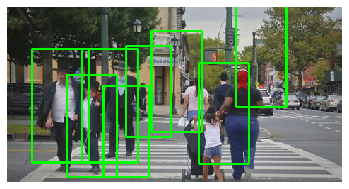

In [22]:
plt.axis("off")
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()

In [23]:
file = open('Saved\\Human_locations_session','wb')
dill.dump_session(file)
file.close()